In this notebook, we share the typical model training and inference on double couple (DC) data, with synthetic Gaussian noise. Note that to reproduce the results on the paper you need to access the entire dataset, which you can obtain by sending an email to [Davide Piras](dr.davide.piras@gmail.com); a smaller dataset is provided here instead, with different results.

### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output  # this has to be removed if used on a single script
import tensorflow as tf
import time
from chainconsumer import ChainConsumer
import json
from utils import PCA_compression, preprocess_coord, preprocess_power, create_observable, create_cov_matrix
# to install this, follow the instructions here:
# https://johannesbuchner.github.io/PyMultiNest/
import pymultinest

### Load and preprocess data

In [2]:
mechanism = 'DC'
smaller = True # change this only if you have access to the full dataset
if smaller:
    total_number_of_receivers = 5
    split = 500  # split between training and non-training
    test_valid = 250 # split between validation and testing    
else:
    # these only make sense if you have access to the entire dataset
    total_number_of_receivers = 23
    split = 8000  # split between training and non-training
    test_valid = 1000 # split between validation and testing    
    
rec_n0 = 0
rec_n1 = rec_n0+total_number_of_receivers
receivers_used = rec_n1 - rec_n0
load_only = True # if True, use pre-trained models; otherwise, train new models
X_dim = 2001 # size of the seismograms
ps_dim = 261 # final frequency component to keep 
power_start = 0 # initial frequency components to discard in the power spectra
pca_dim = 10 # number of PCA components to keep
y_dim = 4 # x, y, z and the distance

In [3]:
# note that this is a subset of those used in the paper; for the full dataset contact Davide Piras
all_data = np.load(f'./data/{mechanism}_data.npy')

In [4]:
# fill data containers
X_data_ = {}
X_data = {}
X_data_valid = {}
X_data_test = {}
power_spectra_before_PCA = {}
seismo_norm_mean, seismo_norm_std, pca_basis = {}, {}, {}
for i in range(total_number_of_receivers):
    X_data_[i] = all_data[i, :X_dim, :].T
    rfft = np.real(np.fft.rfft(X_data_[i]))
    ifft = np.imag(np.fft.rfft(X_data_[i]))
    power_spectra_ = rfft**2. + ifft**2
    power_spectra_ = power_spectra_[:, power_start:ps_dim]
    power_spectra_before_PCA[i] = preprocess_power(power_spectra_, split=split, log=True)
    seismo_norm_mean[i], seismo_norm_std[i], power_spectra, pca_basis[i] = PCA_compression(power_spectra_before_PCA[i], split=split, number_PCA_comp=pca_dim) 
    X_data[i] = power_spectra[:split, :pca_dim]
    X_data_valid[i] = power_spectra[split:split+test_valid, :pca_dim]
    X_data_test[i] = power_spectra[split+test_valid:, :pca_dim]

In [5]:
# load also all coordinates
receiver_coords = np.load('./data/receiver_coords.npy')
if smaller:
    y_data_ = np.load('./data/10000coords.npy')[:1000]
else:
    y_data_ = np.load('./data/10000coords.npy')    
y_data = {}
y_data_valid = {}
y_data_test = {}
for i in range(total_number_of_receivers):
    y_data_preprocessed = preprocess_coord(y_data_, receiver_coords[i], split=split, test_valid=test_valid, std=False)
    y_data[i] = y_data_preprocessed[:split]
    y_data_valid[i] = y_data_preprocessed[split:split+test_valid]
    y_data_test[i] = y_data_preprocessed[split+test_valid:]

### Define the network and train it

In [6]:
# define network; this is done in TF1, since this project is quite old
mb_size = 256 # batch size
act_f = getattr(tf.nn, 'leaky_relu') # activation function
lr = 1e-3

tf.reset_default_graph() # this will eliminate the variables we restored
X = tf.placeholder(tf.float32, shape=[None, pca_dim])
c = tf.placeholder(tf.float32, shape=[None, y_dim])
bsize = tf.placeholder(tf.int32)

h_dims = [256, 256, 256]

def latent_P(coord):
    h = coord
    for i, h_dim in enumerate(h_dims):
        h = tf.layers.dense(h, h_dim, activation=act_f, name = f'layer_{i}')
    logits = tf.layers.dense(h, pca_dim)
    return logits

nn_samples = latent_P(c)

# reconstruction loss
recon_loss_nn = tf.keras.losses.MSE(X, nn_samples)

# loss
loss_nn = tf.reduce_mean(recon_loss_nn)

solver_nn = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss_nn)

saver = tf.train.Saver(max_to_keep=None)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Note that if you decide to re-train it will happen on a smaller dataset than the one in the paper, for which we provide the trained models.

In [7]:
if load_only:
    print('Not training, just loading')
else:
    for i in range(receivers_used):
        print(f'Receiver {rec_n0+i}')
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        losses_rec_nn = []
        valid_losses_rec_nn = []
        
        n_epochs = 20000 # number of epochs
        best_loss = 1e8
        stopping_step = 0
        patience = 50

        for epoch in range(n_epochs):
            # train
            random_perm = np.random.permutation(X_data[rec_n0 + i].shape[0])
            mini_batch_index = 0
            while True:
                indices = random_perm[mini_batch_index:mini_batch_index+mb_size]
                sess.run(solver_nn, feed_dict={X: X_data[rec_n0 + i][indices], c: y_data[rec_n0 + i][indices]})
                mini_batch_index += mb_size
                if mini_batch_index >= X_data[rec_n0 + i].shape[0]:
                    break

            # print metrics
            clear_output(wait=True)

            rec = sess.run(recon_loss_nn, feed_dict={X: X_data[rec_n0 + i], c: y_data[rec_n0 + i]})
            valid_rec = sess.run(recon_loss_nn, feed_dict={X: X_data_valid[rec_n0 + i], c: y_data_valid[rec_n0 + i]})

            losses_rec_nn.append(np.mean(rec))
            valid_losses_rec_nn.append(np.mean(valid_rec))

            print('Epoch: {}'.format(epoch))
            print('Rec loss: {:.4}'.format(np.mean(rec)))
            print('Validation rec loss: {:.4}'.format(np.mean(valid_rec)))


            loss_value = np.mean(valid_rec)
            if loss_value < best_loss:
                stopping_step = 0
                best_loss = loss_value
                save_path = saver.save(sess, f"./saved_models/saved_models_{mechanism}_smaller/best_model_{rec_n0 + i}.ckpt")
            else:
                stopping_step += 1
                print(f'Early stopping: {stopping_step}/{patience}')
            if stopping_step >= patience:
                print('Patience limit reached at epoch {}'.format(epoch))
                break

    fig = plt.figure(figsize=(10, 4))
    plt.plot(losses_rec_nn, label='Training')        
    plt.plot(valid_losses_rec_nn, label='Validation')        
    plt.legend()
    plt.show()

Not training, just loading


### Load models, and evaluate them

In [8]:
# here we need to specify the receivers actually used
#receivers_actually_used = [2, 3, 11, 19, 20]
receivers_actually_used = np.arange(total_number_of_receivers)

# decide if it is going to load the models trained on the smaller dataset,
# or those trained on the full dataset. Note that to reproduce the results of the paper,
# you will need to have both the entire dataset and the provided pre-trained models
load_smaller = True

In [9]:
# load best models
sessions_list = [tf.Session() for _ in range(receivers_used)]
sessions = dict(list(enumerate(sessions_list)))
for i, rec in enumerate(receivers_actually_used):
    print(sessions[i])
    sessions[i].run(tf.global_variables_initializer())
    if load_smaller:
        load_path = (f"./saved_models/saved_models_{mechanism}_smaller/best_model_{rec_n0+rec}.ckpt")
    else:
        load_path = (f"./saved_models/saved_models_{mechanism}/best_model_{rec_n0+rec}.ckpt")
    saver.restore(sessions[i], load_path)

INFO:tensorflow:Restoring parameters from ./saved_models/saved_models_DC_smaller/best_model_0.ckpt
INFO:tensorflow:Restoring parameters from ./saved_models/saved_models_DC_smaller/best_model_1.ckpt
INFO:tensorflow:Restoring parameters from ./saved_models/saved_models_DC_smaller/best_model_2.ckpt
INFO:tensorflow:Restoring parameters from ./saved_models/saved_models_DC_smaller/best_model_3.ckpt
INFO:tensorflow:Restoring parameters from ./saved_models/saved_models_DC_smaller/best_model_4.ckpt


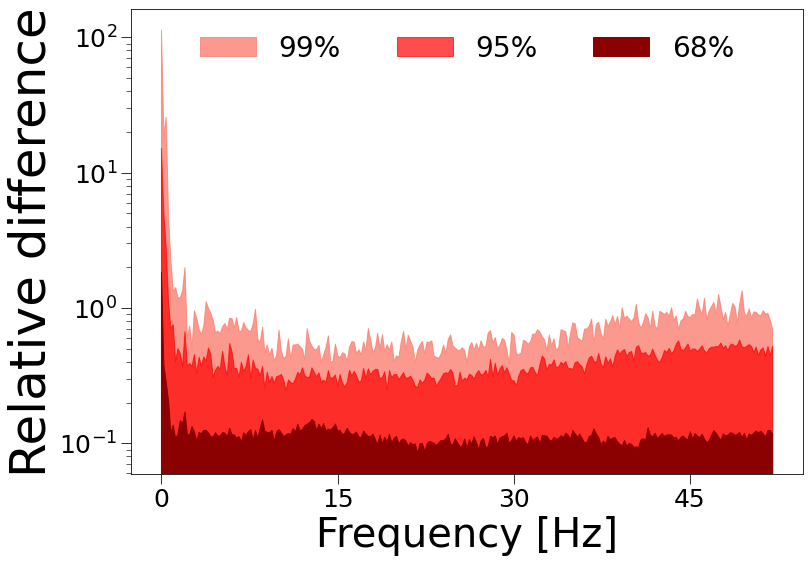

In [10]:
# we add here a figure with the percentile differences from the first receiver
time_step = 5./2001
freqs_iso = np.fft.rfftfreq(2000, time_step)
idx_iso = np.argsort(freqs_iso)

rec = 0
if not smaller:
    rec = 22
prediction_test = sessions[rec].run(nn_samples, feed_dict={c: y_data_test[rec_n0+rec]})
prediction_test_ps = np.matmul(prediction_test, pca_basis[rec_n0+rec])*seismo_norm_std[rec_n0+rec]+seismo_norm_mean[rec_n0+rec]

lrange = freqs_iso[idx_iso][power_start:ps_dim]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

diff = np.abs((power_spectra_before_PCA[rec_n0+rec][split+test_valid:] - prediction_test_ps)/prediction_test_ps)

# compute percentiles
percentiles = np.zeros((4, diff.shape[1]))

percentiles[0] = np.percentile(diff, 68, axis = 0)
percentiles[1] = np.percentile(diff, 95, axis = 0)
percentiles[2] = np.percentile(diff, 99, axis = 0)
ax.fill_between(lrange, 0, percentiles[2,:], color = 'salmon', label = '99%', alpha=0.8)
ax.fill_between(lrange, 0, percentiles[1,:], color = 'red', label = '95%', alpha = 0.7)
ax.fill_between(lrange, 0, percentiles[0,:], color = 'darkred', label = '68%', alpha = 1)


ax.legend(frameon=False, fontsize=28, loc='upper center', ncol=3)
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
ax.set_xlabel('Frequency [Hz]', fontsize=40)
ax.set_ylabel('Relative difference', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.set_yscale('log')
ax.xaxis.set_tick_params(which='major', length=10)
ax.xaxis.set_tick_params(which='minor', length=5)
ax.yaxis.set_tick_params(which='major', length=10)
ax.yaxis.set_tick_params(which='minor', length=5)

### Run inference on a single observed seismogram, with Gaussian noise

In [11]:
observed_id = -2 # a random element of the test set (not in the paper)
scale = 0.3 # noise levels

In [12]:
# caching system
try:
    pymultinest_flag = 1
    os.mkdir(f'./inference/{mechanism}_smaller')
    os.mkdir(f'./inference/{mechanism}_smaller/chains')
    print('Folders created') 
except OSError: 
    pymultinest_flag = 0
    print('WARNING: you have probably run this already, so do not run inference again')

Folders created


In [13]:
new_coords = np.zeros((receivers_used, 4))
shifted = np.zeros((receivers_used, 3))
obs_coord = y_data_[observed_id][:3]

datavectors = {}
invcovmats = {}
for i, rec in enumerate(receivers_actually_used):
    datavectors[i] = create_observable(X_data_[rec_n0+rec][observed_id], 
                                       power_start=power_start, power_cut=ps_dim)
    invcovmats[i] = create_cov_matrix(X_data_[rec_n0+rec][:split], 
                                      power_start=power_start, power_cut=ps_dim)

In [14]:
# multinest functions; no docstrings are provided, but see for a demo:
# https://github.com/JohannesBuchner/PyMultiNest/blob/master/pymultinest_demo.py
def model(coord):
    y_model = {}
    for i, rec in enumerate(receivers_actually_used):
        y_model_PCA = sessions[i].run(nn_samples, feed_dict={c: coord})[i, :]
        y_model[i] = np.matmul(y_model_PCA, pca_basis[rec_n0+rec])*seismo_norm_std[rec_n0+rec]+seismo_norm_mean[rec_n0+rec]
    return tuple(y_model.values())

def myprior(cube, ndim, nparam):
    cube[0] = np.around(cube[0] * 81)
    cube[1] = np.around(cube[1] * 81)
    cube[2] = np.around(cube[2] * 244)
    return

def myloglike(cube, ndim, nparam):
    for i, rec in enumerate(receivers_actually_used):
        for j in range(3):
            shifted[i,j] = cube[j] - receiver_coords[rec_n0+rec,j]
    distances = np.linalg.norm(shifted, axis=1)
    new_coords[:, :3] = shifted
    new_coords[:, -1] = distances
    ymodel = model(new_coords)
    loglikelihood = 0.0
    for i in range(receivers_used):
        diffvec = ymodel[i] - datavectors[i]
        loglikelihood += -0.5 * (np.dot(diffvec.T, np.dot(invcovmats[i], diffvec)))
    return loglikelihood

In [15]:
# number of dimensions our problem has
parameters = ["x", "y", "z"]
n_params = len(parameters)
# name of the output files
prefix = f'./inference/{mechanism}_smaller/chains/prova0-'

In [16]:
# run MultiNest
if pymultinest_flag == 1:
    pymultinest.run(myloglike, myprior, n_params, outputfiles_basename=prefix, resume = False, verbose = True, n_live_points = 1000)
else:
    print('Chain has already been run, so skipping this')

In [17]:
# for marginal plotting, we need to store the parameter names:
with open('%sparams.json' % prefix, 'w') as f:
    json.dump(parameters, f, indent=2)

In [18]:
# convert everything into km
step_size = 1/80
step_size_z = 3/300

def convert_coord(x):
    return (x-1)*step_size

def convert_coord_z(z):
    return (z-1)*step_size_z

obs_coord_km = np.zeros_like(obs_coord)
obs_coord_km[0] = convert_coord(obs_coord[0])
obs_coord_km[1] = convert_coord(obs_coord[1])
obs_coord_km[2] = convert_coord_z(obs_coord[2])

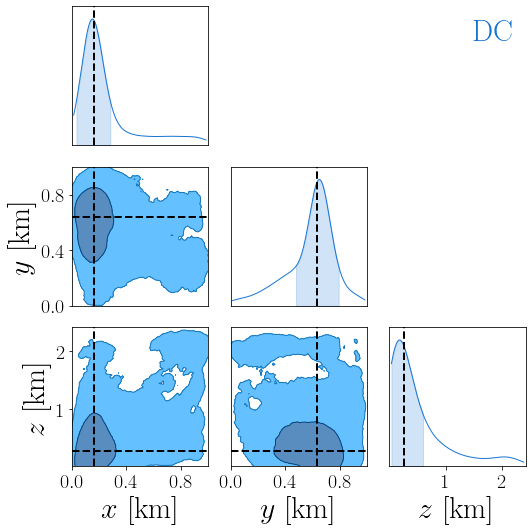

In [19]:
legend = True
data_loaded = np.loadtxt(prefix+'.txt')
x_, y_, z_ = data_loaded[:, 2], data_loaded[:, 3], data_loaded[:, 4]
x_ = convert_coord(x_)
y_ = convert_coord(y_)
z_ = convert_coord_z(z_)
if legend:
    parameters_label = ["$x$ [km]", "$y$ [km]", "$z$ [km]"]
else:
    parameters_label = ["$x$", "$y$", "$z$"]
c_plot = ChainConsumer().add_chain([x_, y_, z_], name=f'{mechanism}', parameters=parameters_label, color='blue')
c_plot.configure(kde=[True], shade_alpha=0.7, flip=False, max_ticks=3, diagonal_tick_labels=False, tick_font_size=20, label_font_size=30, summary=not legend)
c_plot.configure_truth(lw=2)
fig = c_plot.plotter.plot(truth=obs_coord_km, legend=legend)
fig.set_size_inches(3 + fig.get_size_inches())  # Resize fig for doco. You don't need this.
fig.subplots_adjust(left=0.15, right=0.99, top=0.99, bottom=0.10)
fig.tight_layout()

In this particular case, inference is quite decent. However, if you go back and change `load_smaller` to `True`, using the same data but the models trained on the full dataset, you will see a _worse_ peformance. This is due to the degeneracy that can arise since we only consider the power of the seismograms (and not the phase). For this particular event, there are more traces with similar power in different parts of the parameter space, and the models trained on a larger dataset reflect this.

A solution, explored in future work, will be to also learn the phase, in order to break this degeneracy.